# Multilabel Text Classification

## Setting Up Necessary Things

In [ ]:
# Jupyter Notebook Magic Command - Auto Reloading
%reload_ext autoreload
%autoreload 2

# Jupyter Notebook Magic Command - Inline Plotting
%matplotlib inline

In [ ]:
# Ignore All Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# NVIDIA Status
! nvidia-smi

Sun Aug 27 18:58:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/TC.Video.Game

/content/drive/MyDrive/TC.Video.Game


## Necessary Imports

In [ ]:
! pip install -q transformers sentencepiece fastbook fastai ohmeow-blurr nbdev

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

## Data Cleaning

In [ ]:
# Load Data Into DataFrame
df = pd.read_csv("data/raw_data/game_details_kaggle.csv")
df.head()

,Name,Summary,Genres
0,Galactic Bowling,"Galactic Bowling is an exaggerated and stylized bowling game with an intergalactic twist. Players will engage in fast-paced single and multi-player competition while being submerged in a unique new universe filled with over-the-top humor, wild characters, unique levels, and addictive game play. The title is aimed at players of all ages and skill sets. Through accessible and intuitive controls and game-play, Galactic Bowling allows you to jump right into the action. A single-player campaign and online play allow you to work your way up the ranks of the Galactic Bowling League! Whether you h...","['Casual', 'Indie', 'Sports']"
1,Train Bandit,"THE LAW!! Looks to be a showdown atop a train. This will be your last fight. Good luck, Train Bandit. WHAT IS THIS GAME? Train Bandit is a simple score attack game. The Law will attack you from both sides. Your weapon is your keyboard. You'll use those keys to kick the living shit out of the law. React quickly by attacking the correct direction. React...or you're dead. THE FEATURES Unlock new bandits Earn Achievements Become Steam's Most Wanted ? Battle elite officers Kick the law's ass","['Action', 'Indie']"
2,Jolt Project,"Jolt Project: The army now has a new robotics project, jolt. It's up to you to control it and ensure the success of the missions! There are 9 stages of taking the breath away with the right difficulty and good gameplay. Plus an insane way of survival! Fire missiles at cars, tanks, helicopters and turrets! The fun is guaranteed! Use your mouse to aim and shoot and take out the enemies! In this game you will have to be aware of the various enemies who will do everything to destroy your charges and prevent the success of your mission! Cartoon-style graphics are optimized and fun and generate ...","['Action', 'Adventure', 'Indie', 'Strategy']"
3,Henosis™,"HENOSIS™ is a mysterious 2D Platform Puzzler where players are propelled into weird and visceral worlds as they take control of a small, droplet of water while overcoming obstacles and enemies throughout each level. The Player must venture through each world as it collects precious water tokens in order open the exit portal and restore vitality to its drought-ridden home world. Features: Traverse your way through 27 hand-crafted levels Unique player mechanics Battle menacing bosses across 3 distinct worlds* Original artwork &amp; animation Full controller support Localization support * Hid...","['Adventure', 'Casual', 'Indie']"
4,Two Weeks in Painland,"ABOUT THE GAME Play as a hacker who has arranged a deal with a gangster. That’s how the protagonist, Jack, is assigned a mission that should be accomplished in a specific timeframe, which he will find out soon enough. THE GAME’S FEATURES Spy on 4 senior managers within an organization to find out about their personalities. Manage the recruitment process in the organization to improve the work climate. Hack the candidates who want to get into the organization to make your job easier. Try to avoid having your physical health impacted negatively in the process. All of this while you enjoy an ...","['Adventure', 'Indie']"


In [ ]:
# Shape of the DataFrame
df.shape

(76987, 3)

In [ ]:
genres_list = df["Genres"].to_list()    # list of all the genres
genres_count = {}                       # count of all the genres

for genres in genres_list:
  try:
    genre_list = eval(genres)

    for genre in genre_list:
      if genre in genres_count.keys():
        genres_count[genre] += 1
      else:
        genres_count[genre] = 1
  except:
    continue

In [ ]:
print("Total Number of Genres: ", len(genres_count))

sorted_genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))
print("Individual Genres Count: \n", sorted_genres_count)

Total Number of Genres:  33
Individual Genres Count: 
 {'Indie': 51987, 'Casual': 30970, 'Action': 30802, 'Adventure': 28543, 'Simulation': 14602, 'Strategy': 14114, 'RPG': 12966, 'Early Access': 9179, 'Free to Play': 6150, 'Sports': 3402, 'Racing': 2758, 'Massively Multiplayer': 1941, 'Utilities': 781, 'Violent': 509, 'Design & Illustration': 464, 'Animation & Modeling': 380, 'Education': 377, 'Gore': 305, 'Video Production': 269, 'Game Development': 208, 'Software Training': 192, 'Audio Production': 188, 'Photo Editing': 125, 'Nudity': 117, 'Sexual Content': 106, 'Web Publishing': 105, 'Accounting': 22, 'Movie': 2, 'Documentary': 1, 'Episodic': 1, 'Short': 1, 'Tutorial': 1, '360 Video': 1}


### Removing Rare Genres

In [ ]:
threshold = int(len(df) * 0.0025)

rare_genres = [item for item, count in genres_count.items() if count < threshold]

print("Total Rare Genres: ", len(rare_genres))
print("Rare Genres: ", rare_genres)

Total Rare Genres:  12
Rare Genres:  ['Sexual Content', 'Nudity', 'Web Publishing', 'Photo Editing', 'Audio Production', 'Accounting', 'Movie', 'Documentary', 'Episodic', 'Short', 'Tutorial', '360 Video']


In [ ]:
genres_list = df["Genres"].to_list()
revised_genre_list = []
indices_to_drop = []

for idx, genres in enumerate(genres_list):
  try:
    genre_list = eval(genres)
    revised_genres = []

    for genre in genre_list:
      if genre not in rare_genres:
        revised_genres.append(genre)

    if len(revised_genres) == 0:
      indices_to_drop.append(idx)
    else:
      revised_genres_set = set(revised_genres)
      revised_genre_list.append(list(revised_genres_set))
  except:
    indices_to_drop.append(idx)

In [ ]:
df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(74001, 3)

In [ ]:
df["Revised Genres"] = revised_genre_list

In [ ]:
revised_genres_list = df["Revised Genres"].to_list()
revised_genre_count = {}

for genres in revised_genres_list:
  genre_list = genres

  for genre in genre_list:
    if genre in revised_genre_count.keys():
      revised_genre_count[genre] += 1
    else:
      revised_genre_count[genre] = 1

In [ ]:
print("Total Number of Revised Genres: ", len(revised_genre_count))

sorted_revised_genre_count = dict(sorted(revised_genre_count.items(), key=lambda item: item[1], reverse=True))
print("Individual Revised Genres Count: \n", sorted_revised_genre_count)

Total Number of Revised Genres:  21
Individual Revised Genres Count: 
 {'Indie': 51987, 'Casual': 30970, 'Action': 30802, 'Adventure': 28543, 'Simulation': 14602, 'Strategy': 14114, 'RPG': 12966, 'Early Access': 9179, 'Free to Play': 6150, 'Sports': 3402, 'Racing': 2758, 'Massively Multiplayer': 1941, 'Utilities': 781, 'Violent': 509, 'Design & Illustration': 464, 'Animation & Modeling': 380, 'Education': 377, 'Gore': 305, 'Video Production': 269, 'Game Development': 208, 'Software Training': 192}


In [ ]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(revised_genre_count.items())}

with open("encrypted/kaggle/genre_types_encoded_kaggle.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [ ]:
encode_genre_types

{'Indie': 0,
 'Sports': 1,
 'Casual': 2,
 'Action': 3,
 'Adventure': 4,
 'Strategy': 5,
 'Free to Play': 6,
 'RPG': 7,
 'Massively Multiplayer': 8,
 'Simulation': 9,
 'Early Access': 10,
 'Racing': 11,
 'Utilities': 12,
 'Education': 13,
 'Violent': 14,
 'Gore': 15,
 'Design & Illustration': 16,
 'Animation & Modeling': 17,
 'Game Development': 18,
 'Software Training': 19,
 'Video Production': 20}

In [ ]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
revised_genres_list = df["Revised Genres"].to_list()

for revised_genres in revised_genres_list:
  categorical_list = [0] * len(encode_genre_types)

  for genre in revised_genres:
    if genre in encode_genre_types:
      genre_type_index = encode_genre_types[genre]
      categorical_list[genre_type_index] = 1

  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
df["Genre Cat List"] = categorical_genre_list

In [ ]:
df.head()

,Name,Summary,Genres,Revised Genres,Genre Cat List
0,Galactic Bowling,"Galactic Bowling is an exaggerated and stylized bowling game with an intergalactic twist. Players will engage in fast-paced single and multi-player competition while being submerged in a unique new universe filled with over-the-top humor, wild characters, unique levels, and addictive game play. The title is aimed at players of all ages and skill sets. Through accessible and intuitive controls and game-play, Galactic Bowling allows you to jump right into the action. A single-player campaign and online play allow you to work your way up the ranks of the Galactic Bowling League! Whether you h...","['Casual', 'Indie', 'Sports']","[Indie, Sports, Casual]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Train Bandit,"THE LAW!! Looks to be a showdown atop a train. This will be your last fight. Good luck, Train Bandit. WHAT IS THIS GAME? Train Bandit is a simple score attack game. The Law will attack you from both sides. Your weapon is your keyboard. You'll use those keys to kick the living shit out of the law. React quickly by attacking the correct direction. React...or you're dead. THE FEATURES Unlock new bandits Earn Achievements Become Steam's Most Wanted ? Battle elite officers Kick the law's ass","['Action', 'Indie']","[Indie, Action]","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Jolt Project,"Jolt Project: The army now has a new robotics project, jolt. It's up to you to control it and ensure the success of the missions! There are 9 stages of taking the breath away with the right difficulty and good gameplay. Plus an insane way of survival! Fire missiles at cars, tanks, helicopters and turrets! The fun is guaranteed! Use your mouse to aim and shoot and take out the enemies! In this game you will have to be aware of the various enemies who will do everything to destroy your charges and prevent the success of your mission! Cartoon-style graphics are optimized and fun and generate ...","['Action', 'Adventure', 'Indie', 'Strategy']","[Adventure, Action, Strategy, Indie]","[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Henosis™,"HENOSIS™ is a mysterious 2D Platform Puzzler where players are propelled into weird and visceral worlds as they take control of a small, droplet of water while overcoming obstacles and enemies throughout each level. The Player must venture through each world as it collects precious water tokens in order open the exit portal and restore vitality to its drought-ridden home world. Features: Traverse your way through 27 hand-crafted levels Unique player mechanics Battle menacing bosses across 3 distinct worlds* Original artwork &amp; animation Full controller support Localization support * Hid...","['Adventure', 'Casual', 'Indie']","[Adventure, Indie, Casual]","[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Two Weeks in Painland,"ABOUT THE GAME Play as a hacker who has arranged a deal with a gangster. That’s how the protagonist, Jack, is assigned a mission that should be accomplished in a specific timeframe, which he will find out soon enough. THE GAME’S FEATURES Spy on 4 senior managers within an organization to find out about their personalities. Manage the recruitment process in the organization to improve the work climate. Hack the candidates who want to get into the organization to make your job easier. Try to avoid having your physical health impacted negatively in the process. All of this while you enjoy an ...","['Adventure', 'Indie']","[Adventure, Indie]","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
# Drop Duplicate Summary from the DataFrame
df = df.drop_duplicates(subset = "Summary", keep='first')

In [ ]:
# Drop Genres Column
df.drop(["Genres"], axis = 1, inplace = True)

In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
df.isna().sum()

Name              0
Summary           0
Revised Genres    0
Genre Cat List    0
dtype: int64

In [ ]:
# Shuffle DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Description of The DataFrame
df.describe(include="object")

,Name,Summary,Revised Genres,Genre Cat List
count,73551,73551,73551,73551
unique,73057,73551,2017,2016
top,Alone,"Deep in the woods of the Tatras Mountains, supplies dwindle and flood waters are rising. It’s up to you to keep spirits high and make the most of your survival skills. Will you butter up the right person? Or will you wind up on the chopping block? Featuring Eastern European folklore in an unexpected package, Cooking Companions is a “dating sim” psychological horror title you won't soon forget. Players will be able to unlock 40 Steam achievements, 55+ pieces of artwork, four vegan recipes and 7 endings. WARNING: This game may potentially trigger seizures for people with photosensitive epile...","[Indie, Casual]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
freq,5,1,4300,4300


## Data-Loaders and Modeling

In [ ]:
labels = list(encode_genre_types.keys())

In [ ]:
model_name = "distilroberta-base"

model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)

hf_model.config.problem_type = "multi_label_classification"

In [ ]:
blocks = (
    TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
    MultiCategoryBlock(encoded=True,vocab=labels)
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("Summary"),
    get_y=ColReader("Genre Cat List"),
    splitter=RandomSplitter(valid_pct=0.1, seed=42)
)

In [ ]:
dls = dblock.dataloaders(df, bs=32)

torch.save(dls, "dataloaders/kaggle/dls-multilabel-game-classifier-kaggle.pkl")

In [ ]:
dls.vocab

['Indie', 'Sports', 'Casual', 'Action', 'Adventure', 'Strategy', 'Free to Play', 'RPG', 'Massively Multiplayer', 'Simulation', 'Early Access', 'Racing', 'Utilities', 'Education', 'Violent', 'Gore', 'Design & Illustration', 'Animation & Modeling', 'Game Development', 'Software Training', 'Video Production']

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,游戏简介： 【三国挂机卡牌+3DQ版】瞩目登场 ●上线送千抽，开局就VIP6！ ●零氪挂机不掉队，散人轻松好上位！ ●福利首充，福利月卡，免费送随便拿！ ●武将配阵千变万化，小R逆袭绝不夸大！ ●兵符、兵法，技能随意搭，三国纵横笑哈哈； ●群雄逐鹿，平定中原，玩法丰富，跨服争霸。 上线福利： 1、上线送VIP6； 2、送武将千抽自选（玩家升级到一定等级可进行3次十连抽，自选中意的一组，可多次领取） 3、七日登录，送魏蜀吴5星名将； 4、推关送5星赵云、5星神·赵云； 5、充值达标，月卡免费领，每日领取免,"[Casual, Strategy, Free to Play, RPG, Early Access, Racing]"
1,【游戏特色】 1、独立开发推理解谜RPG游戏 2、以写实风格进行场景设计，80-90年代中国大陆本土风情 3、原创连续剧情，推理解谜为基础元素 4、本季继承第一、二、三、四季的玩法，并加入更多的新的玩法 5、这是第五季的故事，Enjoy! S05E01 《徽州古宅:蝶儿》 我生下来就没有名字，爹妈养我就是要送到宫里。我喜欢蝴蝶，它们美丽又自由。我叫自己蝶儿。我以为我的一生早成定数，直到遇见你。 听说，我降生时，是夏天，院子里的腊梅开花了，因此取名小梅。我6岁时，爸爸妈妈被一种奇怪的病折磨而死，去世时已无人形。一个姓夏的大管家收留了我，�,"[Indie, Adventure, RPG]"
2,-. --- -...... -. --. -.......... -...-... -... -. -. --- -...... -. --. -.......... -...-... -... -. -. --- -...... -. --. -.......... -...-... -... -..- - -..... -.... --... -. -... -. --. -. --- -...... -. --. -.......... -...-... -... -. -. --- -...... -. --. -.......... -...-... -... -. -. --- -...... -. --. -.......... -...-... -... -. -. --- -...... -. --. -.......... -...-... -... -. -. --- -...... -. --. -.......... -...-... -... -. -. --- -...... -. --. -........ -......-....... -. --- -...... -.,"[Indie, Adventure, Early Access]"
3,《风色幻想Ⅲ：罪与罚的镇魂歌》是弘煜科技研发的一款战略角色扮演游戏，游戏剧情接承《魔导圣战：风色幻想》。精灵与人类之战后的近百年时光，人类帝国为了抵御灭世灾难而组建起精英组织“断罪之翼”。其中，白发少女凯琳与少年将军西撒分别加入了断罪之翼，与其他伙伴共同面对预言中的毁灭神罚，以及在危机弭去后各国之间的纷争。 【游戏特色】 最新３Ｄ引擎技术导入，突破传统２Ｄ印象的高完美战略性完整呈现 大受好评的真实行动点数ＲＡＰ系统再强化，更自由的战略应用尽操您手 职业分工概念�,"[Adventure, Strategy, RPG]"


In [ ]:
doc(accuracy_multi)

In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[acc_02],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter
).to_fp16()

## Stage: 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0012022644514217973, valley=0.00019054606673307717)

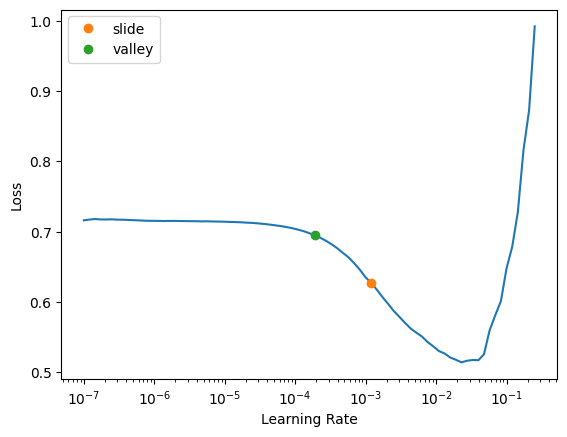

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(1, 5.5e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.188266,0.181603,0.894843,09:45


In [ ]:
learner.save("kaggle/game-ml-classifier-stage-kaggle-0")

Path('models/game-ml-classifier-stage-kaggle-0.pth')

In [ ]:
learner.export("models/kaggle/game-ml-classifier-stage-kaggle-0.pkl")

## Stage: 1

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.004365158267319202, valley=1.4454397387453355e-05)

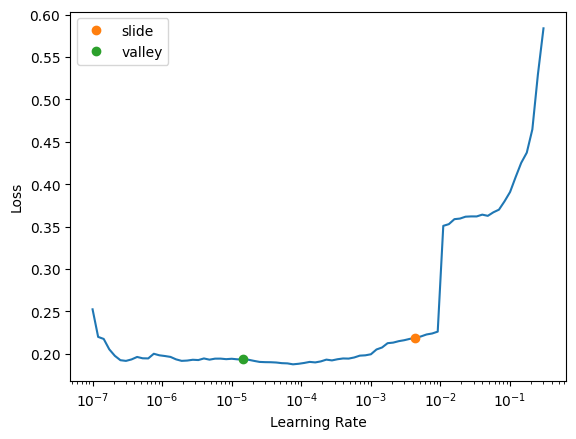

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(3,slice(4.75e-3, 1.25e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.199257,0.191570,0.889081,12:09
1,0.173585,0.181749,0.889799,12:01


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.199257,0.191570,0.889081,12:09
1,0.173585,0.181749,0.889799,12:01
2,0.138075,0.186464,0.904302,12:06


In [ ]:
learner.save("kaggle/game-ml-classifier-stage-kaggle-1")

Path('models/game-ml-classifier-stage-kaggle-1.pth')

In [ ]:
learner.export("models/kaggle/game-ml-classifier-stage-kaggle-1.pkl")

## Data Split

In [ ]:
splitter = RandomSplitter(valid_pct=0.1, seed=42)

train_ids, valid_ids = splitter(df)

print("Train Len: ", len(train_ids))
print("Valid Len: ", len(valid_ids))

Train Len:  66196
Valid Len:  7355


In [ ]:
valid_df = df.loc[valid_ids]

print("Valid Data: ")
valid_df.head()

Valid Data: 


,Name,Summary,Revised Genres,Genre Cat List
3621,Space Runaway,"Space Runaway, a compelling intergalactic journey soaked in bullet hell. Enemy vessels, lasers and larger than life bosses coming at you full speed in a 16-bit authentic arcade experience like no other. Not only an integral part of Wanted: Dead, Space Runaway is a standalone game that features 7 unique stages that will test your reflexes. Space Runaway will be available as an arcade mini-game within Wanted: Dead and is now available for free to give a taste of things to come on Valentine’s Day 2023. Key features: 7 challenging levels to test your arcade skills to the limit. 7 epic bosses t...",[Action],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
21368,Urban Mage,"Urban Mage is a score attack, fast-paced, top-down, competitive game. Become a powerful dark mage and kill everyone in sight with a single click. Find hidden interactions as you destroy cars, lamps and dumpsters. Collect the highest score possible as the precious timer ticks away! Each play only gives you a limited amount of time to explore and reach as high of a score as you can. You won't do well on your first attempt. After playing the level a few times you'll start to develop a strategy for reaching the highest score possible. Don't forget to also keep the combo! Challenge Mode - Timed...","[Action, Casual]","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
67045,Snake: Road to apple,"Snake: Road to Apple snake is a nice classic game. Eating apples, earn points. Earn a maximum of points! Simple and addictive gameplay Use arrow keys to move",[Action],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
241,Excalibots,"Collect swords, fight goblins, and save the kingdom in this fun, cartoony hack-and-slash! Play as the sword-obsessed knight Percy as he sets out to find the best, shiniest swords out there with the help of his trusty squire, Penelope. On the way, he'll explore colorful locales, meet a cast of charming characters, and fight his way through a whole goblin invasion! In taking the role of a knight, you will have to master the ability to fight with different weapons against a variety of foes. Don't get too comfortable with any one blade! Even the finest weapon is prone to wear and might shatter...","[Adventure, Action, Free to Play]","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
49968,Golden Mine Pickaxe 2: Mummy Tombs,"Golden Mine Pickaxe 2 is a sequel to the sandbox game of the same name with RPG elements. Your hero goes to ancient tombs to find even more gold and new resources. But he is met with a surprise - revived mummies who will do everything to take away what they found. Move deeper into the tombs, upgrade your weapons and defeat new enemies to collect as many resources as possible! Peculiarities: - Random level generation. - Nice graphics. - Elements of pumping the character and weapons.",[Casual],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Evaluation

In [ ]:
! pip install -q ohmeow-blurr

In [ ]:
learner_inf = learner

In [ ]:
from sklearn import metrics

def metric_measures(test_df, preds):

  targets = [np.asarray(target) for target in test_df['Genre Cat List'].to_list()]
  outputs = [np.asarray(pred) for pred in preds]


  accuracy = metrics.accuracy_score(targets, outputs)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

  print(f"F1 Score (Micro) = {f1_score_micro}")
  print(f"F1 Score (Macro) = {f1_score_macro}")

  return

In [ ]:
from tqdm.notebook import tqdm

preds = []
for idx, row in tqdm(valid_df.iterrows(), total=len(valid_df)):
  desc = row['Summary']
  labels = learner_inf.blurr_predict(desc)[0]['labels']
  pred_genres = [0] * len(encode_genre_types)
  for label in labels:
    pred_genres[encode_genre_types[label]] = 1
  preds.append(pred_genres)

preds[0][:20]

  0%|          | 0/7355 [00:00<?, ?it/s]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
metric_measures(valid_df, preds)

F1 Score (Micro) = 0.7065942822990338
F1 Score (Macro) = 0.49815645497302957
